# Dissecting the VAE

A notebook for messing with the Oasis VAE... make sure you put the `vit-l-20.safetensors` into the `checkpoints/oasis` dir

In [9]:
device = "cuda"

In [33]:
import torch
from world_mar.oasis_utils.vae import AutoencoderKL
from omegaconf import OmegaConf
from world_mar.modules.utils import instantiate_from_config
from world_mar.dataset.dataloader import MinecraftDataModule

import matplotlib.pyplot as plt

In [24]:
cfg = OmegaConf.load("configs/world_mar.yaml")
world_mar = instantiate_from_config(cfg.model)
world_mar.to(device)
vae = world_mar.vae

In [ ]:
minecraft_dataloader = instantiate_from_config(cfg.dataloader).train_dataloader()

FINISHED PREPROCESSING ALL METADATA: 204.59852147102356


In [ ]:
latent_frame = minecraft_dataloader.train_dataset.__getitem__(100)

In [45]:
latents_pred = latent_frame["frames"][0].unsqueeze(0).to(device)
latents_pred.shape

torch.Size([1, 576, 16])

In [61]:
null_pred = 10 * torch.randn_like(latents_pred, device=device) + latents_pred

In [62]:
decoded = vae.decode(null_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.583302..1.5952659].


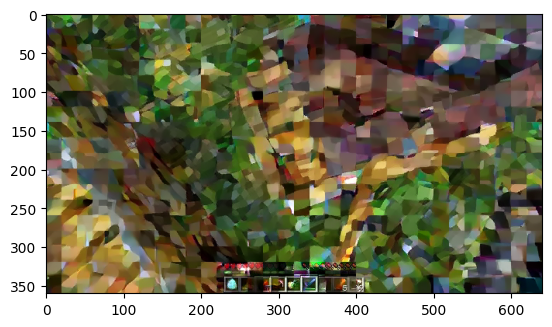

In [63]:
plt.imshow((((decoded[0] + 1) / 2)).permute(1,2,0).cpu())

## Latent Statistics

In [ ]:
n_batches = 10

sum_latent = torch.zeros(1, 576, 16, device=device)
sum_sq_latent = torch.zeros_like(sum_latent)
sum_norm = 0.0
sum_sq_norm = 0.0

for i, batch in enumerate(data):
    x = batch["frames"][:, 0, :, :].to(device)
    sum_latent    += x.mean(dim=0, keepdim=True)
    sum_sq_latent += (x**2).mean(dim=0, keepdim=True)

    norms = x.view(x.size(0), -1).norm(dim=1)
    sum_norm    += norms.mean().item()
    sum_sq_norm += (norms**2).mean().item()

    if i + 1 == n_batches:
        break

mean_latent = sum_latent / n_batches
mean_norm   = sum_norm   / n_batches

var_latent = sum_sq_latent / n_batches - mean_latent**2
var_norm   = sum_sq_norm   / n_batches - mean_norm**2

print("Component means:",   mean_latent)
print("Component variances:", var_latent)
print("Norm mean:",         mean_norm)
print("Norm variance:",     var_norm)

Component means: tensor([[[-1.0443, -1.5410,  1.4304,  ..., -1.6043, -4.6731,  3.2268],
         [-0.9100, -1.3855,  1.2263,  ..., -1.2183, -4.5528,  3.0274],
         [-1.1629, -1.1287,  1.9035,  ..., -2.1684, -4.6380,  2.5738],
         ...,
         [-5.3042,  1.5089,  4.6921,  ..., -2.9236, -4.0304,  8.5940],
         [-7.2635,  3.8643,  4.2157,  ..., -1.0681, -3.5821,  7.8125],
         [-7.0180, -0.2434,  4.7903,  ..., -0.4946, -3.4871,  8.2439]]],
       device='cuda:0')
Component variances: tensor([[[170.2856,  96.2054, 120.0613,  ..., 101.1536, 134.5695, 146.9546],
         [160.1458,  97.0122, 129.6561,  ..., 100.5724, 138.2248, 150.5989],
         [173.3092, 105.5495, 113.0163,  ..., 111.3321, 133.1557, 155.0520],
         ...,
         [167.6155, 147.3971,  92.1440,  ..., 134.6331, 162.3336, 117.5010],
         [138.5017, 198.1833,  97.4820,  ..., 119.5468, 143.3715, 130.8617],
         [161.5592, 139.9258,  95.8726,  ..., 133.9859, 167.8472, 137.7259]]],
       device='cud

In [82]:
var_latent.mean().sqrt()

tensor(11.0694, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15806347..1.0730569].


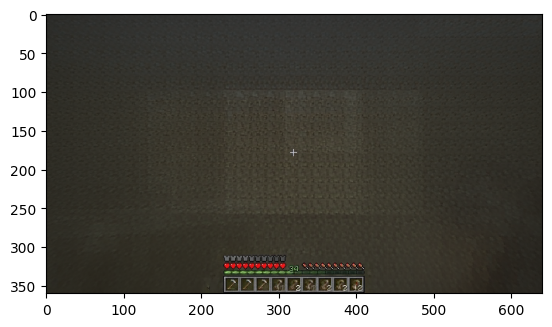

In [76]:
decoded_mean = vae.decode(mean_latent)
plt.imshow((((decoded_mean[0] + 1) / 2)).permute(1,2,0).cpu())